In [64]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

import numpy as np
import torch

import pickle

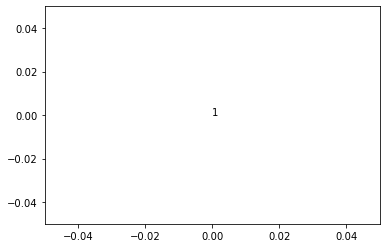

In [4]:
plt.text(0, 0, '1')
plt.autoscale(enable=True, tight=True)
plt.show()

In [60]:
EMPTY_PIXEL = np.array([255, 255, 255], dtype=np.uint8)
EMPTY_TENSOR_PIXEL = torch.tensor([1., 1., 1.], dtype=torch.float32).view(3, 1, 1)

GRAYSCALE_WEIGHTS = np.array([0.2989, 0.5870, 0.1140]) 
DEFAULT_THRESHOLD = 0.2

def find_non_empty_indices(X, empty_value=EMPTY_PIXEL, color_axis=2):
    if isinstance(X, np.ndarray):
        if not isinstance(empty_value, np.ndarray):
            raise ValueError('Expected empty_value to be a numpy array when X is a numpy array')

        empty_pixels = (X[:, :, :-1] == empty_value).all(axis=color_axis)
        non_empty_rows = ~(empty_pixels.all(axis=1))
        non_empty_cols = ~(empty_pixels.all(axis=0))
        
        first_non_empty_row = non_empty_rows.argmax()
        last_non_empty_row = non_empty_rows.shape[0] - non_empty_rows[::-1].argmax()

        first_non_empty_col = non_empty_cols.argmax() 
        last_non_empty_col = non_empty_cols.shape[0] - non_empty_cols[::-1].argmax()

    elif isinstance(X, torch.Tensor):
        if not isinstance(empty_value, torch.Tensor):
            raise ValueError('Expected empty_value to be a torch tensor when X is a torch tensor')

        empty_pixels = (X == empty_value).all(dim=color_axis)
        if empty_pixels.dim() == 3:
            empty_pixels = empty_pixels.all(dim=0)
        non_empty_rows = (~(empty_pixels.all(dim=1))).double()  # torch doesn't support argmax for booleans
        non_empty_cols = (~(empty_pixels.all(dim=0))).double()
        
        first_non_empty_row = non_empty_rows.argmax()
        last_non_empty_row = non_empty_rows.shape[0] - non_empty_rows.flip(0).argmax()

        first_non_empty_col = non_empty_cols.argmax() 
        last_non_empty_col = non_empty_cols.shape[0] - non_empty_cols.flip(0).argmax()

    else:
        raise ValueError('Expected X to be a numpy array or a torch tensor')


    return first_non_empty_row, last_non_empty_row, first_non_empty_col, last_non_empty_col

def _text_to_array(text, size, xlim=None, ylim=None, fontsize=16, threshold=DEFAULT_THRESHOLD):
    fig = Figure(figsize=(4, 4))
    # attach a non-interactive Agg canvas to the figure
    # (as a side-effect of the ``__init__``)
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    max_size = max(size)

    if xlim is None:
        ax.set_xlim(-max_size, max_size)
    else:
        ax.set_xlim(*xlim)

    if ylim is None:
        ax.set_ylim(-max_size, max_size)
    else:
        ax.set_ylim(*ylim)

    ax.set_facecolor('white')
    ax.text(0, 0, text, fontsize=fontsize)
    ax.set_axis_off()
    # ax.autoscale(tight=True)
    # Force a draw so we can grab the pixel buffer
    canvas.draw()
    # grab the pixel buffer and dump it into a numpy array
    X = np.array(canvas.renderer.buffer_rgba())

    first_non_empty_row, last_non_empty_row, first_non_empty_col, last_non_empty_col = find_non_empty_indices(X)
    X_trim = X[first_non_empty_row:last_non_empty_row, first_non_empty_col:last_non_empty_col, :]
    h, w = X_trim.shape[:2]
    square_size = max(w, h)
    h_pad = (square_size - h) // 2
    w_pad = (square_size - w) // 2
    X_pad = np.pad(X_trim, ((h_pad, h_pad), (w_pad, w_pad), (0, 0)), mode='constant', constant_values=255)

    X_grayscale = (GRAYSCALE_WEIGHTS.reshape(1, 1, 3) * X_pad[:, :, :-1].astype(float) / 255).sum(-1)
    X_alpha = (X_pad[:, :, -1].astype(float) / 255)
    return ((1 - X_grayscale) * X_alpha > threshold).astype(np.uint8)




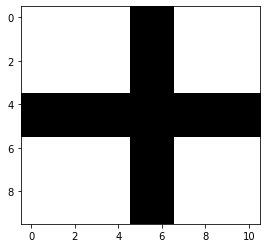

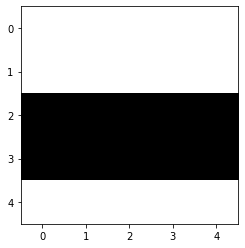

In [77]:
text_to_array_dict = dict()

for i in range(0, 11):
    X = _text_to_array(str(i), (2, 2))
    text_to_array_dict[str(i)] = X
    # plt.imshow(X, cmap='gray_r')
    # plt.show()


OTHER_SYMBOLS = '+-'

for symbol in OTHER_SYMBOLS:
    X = _text_to_array(symbol, (2, 2), threshold=0.05)
    text_to_array_dict[symbol] = X
    plt.imshow(X, cmap='gray_r')
    plt.show()

with open('../gym_minigrid/text_to_array.pkl', 'wb') as f:
    pickle.dump(text_to_array_dict, f)



In [66]:
X.shape

(18, 18)

In [78]:
l = ['a=b', 'c=d']
dict(x.split('=') for x in l)

{'a': 'b', 'c': 'd'}